In [2]:
with open("out.tr", "r") as f:
    data = f.readlines()

In [3]:
EVENT, TIME, FROM_NODE, TO_NODE, PACKET_TYPE, PACKET_SIZE, FLAGS, FID, SOURCE_ADDRESS, DST_ADDRESS, SEQ_NUM, PKT_ID = [i for i in range(12)]

In [4]:
def filterPackets(data, condition):
    result = []
    for line in data:
        items = line.split()
        conditionSatisfied = True
        for key, value in condition.items():
            if items[key] != value:
                conditionSatisfied = False
                break
        if conditionSatisfied:
            result.append(items)
    return result

In [5]:
def getTotalPacketsSize(connection):
    return sum([int(packets[PACKET_SIZE]) for packets in connection])

In [6]:
tcp0Condition = {TO_NODE: '5', EVENT: 'r'}
tcp1Condition = {TO_NODE: '6', EVENT: 'r', PACKET_TYPE: 'tcp'}
tcp2Condition = {TO_NODE: '7', EVENT: 'r'}
udpCondition = {TO_NODE: '6', EVENT: 'r', PACKET_TYPE: 'cbr'}
ack0Condition = {FROM_NODE: '5', TO_NODE: '4', EVENT: '+'}
ack1Condition = {FROM_NODE: '6', TO_NODE: '4', EVENT: '+'}
ack2Condition = {FROM_NODE: '7', TO_NODE: '4', EVENT: '+'}
tcp0PacketSum = getTotalPacketsSize(filterPackets(data, tcp0Condition))
tcp1PacketSum = getTotalPacketsSize(filterPackets(data, tcp1Condition))
tcp2PacketSum = getTotalPacketsSize(filterPackets(data, tcp2Condition))
ack0PacketSum = getTotalPacketsSize(filterPackets(data, ack0Condition))
ack1PacketSum = getTotalPacketsSize(filterPackets(data, ack1Condition))
ack2PacketSum = getTotalPacketsSize(filterPackets(data, ack2Condition))
udpPacketSum = getTotalPacketsSize(filterPackets(data, udpCondition))
print("Average Throughput of TCP0:", (tcp0PacketSum + ack0PacketSum) / 10)
print("Average Throughput of TCP1:", (tcp1PacketSum + ack1PacketSum) / 10)
print("Average Throughput of TCP2:", (tcp2PacketSum + ack2PacketSum) / 10)
print("Average Throughput of UDP:", udpPacketSum / 1)

Average Throughput of TCP0: 110384.0
Average Throughput of TCP1: 38564.0
Average Throughput of TCP2: 35432.0
Average Throughput of UDP: 128000.0


In [7]:
def getDelayAndAmount(data, startCondition, endCondition):
    sentPackets = filterPackets(data, startCondition)
    startTime = {}
    for item in sentPackets:
        startTime[item[PKT_ID]] = float(item[TIME])
    receivedPackets = filterPackets(data, endCondition)
    totalDelay = 0
    for item in receivedPackets:
        totalDelay += float(item[TIME]) - startTime[item[PKT_ID]]
    return len(receivedPackets), totalDelay

In [8]:
tcp0Count, tcp0Delay = getDelayAndAmount(data, {FROM_NODE: '0', TO_NODE: '3', EVENT: '+'}, {FROM_NODE: '4', TO_NODE: '5', EVENT: 'r'})
ack0Count, ack0Delay = getDelayAndAmount(data, {FROM_NODE: '5', TO_NODE: '4', EVENT: '+'}, {FROM_NODE: '3', TO_NODE: '0', EVENT: 'r'})
print("Average Delay of TCP0:", (tcp0Delay + ack0Delay) / (tcp0Count + ack0Count))

tcp1Count, tcp1Delay = getDelayAndAmount(data, {FROM_NODE: '1', TO_NODE: '3', EVENT: '+', PACKET_TYPE: 'tcp'}, {FROM_NODE: '4', TO_NODE: '6', EVENT: 'r', PACKET_TYPE: 'tcp'})
ack1Count, ack1Delay = getDelayAndAmount(data, {FROM_NODE: '6', TO_NODE: '4', EVENT: '+'}, {FROM_NODE: '3', TO_NODE: '1', EVENT: 'r'})
print("Average Delay of TCP1:", (tcp1Delay + ack1Delay) / (tcp1Count + ack1Count))

tcp2Count, tcp2Delay = getDelayAndAmount(data, {FROM_NODE: '2', TO_NODE: '3', EVENT: '+'}, {FROM_NODE: '4', TO_NODE: '7', EVENT: 'r'})
ack2Count, ack2Delay = getDelayAndAmount(data, {FROM_NODE: '7', TO_NODE: '4', EVENT: '+'}, {FROM_NODE: '3', TO_NODE: '2', EVENT: 'r'})
print("Average Delay of TCP2:", (tcp2Delay + ack2Delay) / (tcp2Count + ack2Count))

udpCount, udpDelay = getDelayAndAmount(data, {FROM_NODE: '1', TO_NODE: '3', EVENT: '+', PACKET_TYPE: 'cbr'}, {FROM_NODE: '4', TO_NODE: '6', EVENT: 'r', PACKET_TYPE: 'cbr'})
print("Average Delay of UDP:", udpDelay / udpCount)

Average Delay of TCP0: 0.11958738074291253
Average Delay of TCP1: 0.12892446508379893
Average Delay of TCP2: 0.1026511139817629
Average Delay of UDP: 0.29460734375


Text(0, 0.5, 'Sequence number')

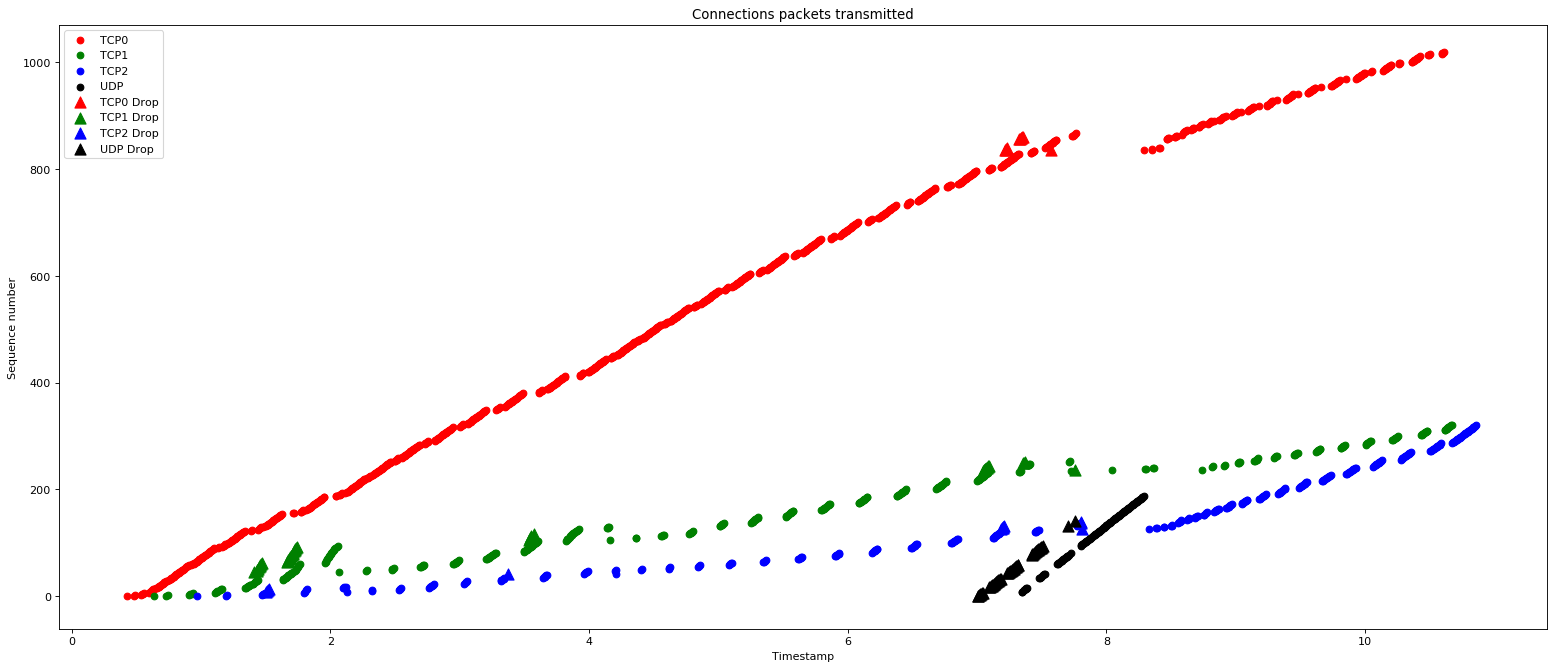

In [48]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(24, 10), dpi=80)
tcp0r = filterPackets(data, tcp0Condition)
tcp1r = filterPackets(data, tcp1Condition)
tcp2r = filterPackets(data, tcp2Condition)
udpR = filterPackets(data, udpCondition)
ack0Condition = {EVENT: 'r', FROM_NODE: '3', TO_NODE: '0'}
ack1Condition = {EVENT: 'r', FROM_NODE: '3', TO_NODE: '1'}
ack2Condition = {EVENT: 'r', FROM_NODE: '3', TO_NODE: '2'}
ack0 = filterPackets(data, ack0Condition)
ack1 = filterPackets(data, ack1Condition)
ack2 = filterPackets(data, ack2Condition)
drop0, drop1, drop2, dropUDP = [], [], [], [] 
for line in data:
    item = line.strip().split()
    if item[EVENT] == 'd':
        if int(float(item[SOURCE_ADDRESS])) == 0:
            drop0.append(item)
        elif int(float(item[SOURCE_ADDRESS])) == 2:
            drop2.append(item)
        elif item[PACKET_TYPE] == 'tcp':
            drop1.append(item)
        else:
            dropUDP.append(item)
plt.scatter([float(item[TIME]) for item in tcp0r], [int(item[SEQ_NUM]) for item in tcp0r], c='red', label='TCP0')
plt.scatter([float(item[TIME]) for item in tcp1r], [int(item[SEQ_NUM]) for item in tcp1r], c='green', label='TCP1')
plt.scatter([float(item[TIME]) for item in tcp2r], [int(item[SEQ_NUM]) for item in tcp2r], c='blue', label='TCP2')
plt.scatter([float(item[TIME]) for item in udpR], [int(item[SEQ_NUM]) for item in udpR], c='black', label='UDP')
plt.scatter([float(item[TIME]) for item in drop0], [int(item[SEQ_NUM]) for item in drop0], marker='^', s=100, c='red', label='TCP0 Drop')
plt.scatter([float(item[TIME]) for item in drop1], [int(item[SEQ_NUM]) for item in drop1], marker='^', s=100, c='green', label='TCP1 Drop')
plt.scatter([float(item[TIME]) for item in drop2], [int(item[SEQ_NUM]) for item in drop2], marker='^', s=100, c='blue', label='TCP2 Drop')
plt.scatter([float(item[TIME]) for item in dropUDP], [int(item[SEQ_NUM]) for item in dropUDP], marker='^', s=100, c='black', label='UDP Drop')
plt.legend()
plt.title("Connections packets transmitted")
plt.xlabel("Timestamp")
plt.ylabel("Sequence number")

In [32]:
startTCP0, startTCP1, startTCP2, startUDP = {}, {}, {}, {}
pkt_id0, pkt_id1, pkt_id2, pkt_id3 = [], [], [], []
delay0, delay1, delay2, delay3 = [], [], [], []
for line in data:
    item = line.strip().split()
    if item[EVENT] == '+':
        if item[FROM_NODE] == '0' and item[TO_NODE] == '3':
            startTCP0[item[PKT_ID]] = item[TIME]
        elif item[FROM_NODE] == '1' and item[TO_NODE] == '3' and item[PACKET_TYPE] == 'tcp':
            startTCP1[item[PKT_ID]] = item[TIME]
        elif item[FROM_NODE] == '2' and item[TO_NODE] == '3':
            startTCP2[item[PKT_ID]] = item[TIME]
        elif item[FROM_NODE] == '1' and item[TO_NODE] == '3' and item[PACKET_TYPE] == 'cbr':
            startUDP[item[PKT_ID]] = item[TIME]
    elif item[EVENT] == 'r':
        if item[FROM_NODE] == '4' and item[TO_NODE] == '5':
            pkt_id0.append(float(item[TIME]))
            delay0.append(float(item[TIME]) - float(startTCP0[item[PKT_ID]]))
        elif item[FROM_NODE] == '4' and item[TO_NODE] == '6' and item[PACKET_TYPE] == 'tcp':
            pkt_id1.append(float(item[TIME]))
            delay1.append(float(item[TIME]) - float(startTCP1[item[PKT_ID]]))
        elif item[FROM_NODE] == '4' and item[TO_NODE] == '7':
            pkt_id2.append(float(item[TIME]))
            delay2.append(float(item[TIME]) - float(startTCP2[item[PKT_ID]]))
        elif item[FROM_NODE] == '4' and item[TO_NODE] == '6' and item[PACKET_TYPE] == 'cbr':
            pkt_id3.append(float(item[TIME]))
            delay3.append(float(item[TIME]) - float(startUDP[item[PKT_ID]]))

Text(0, 0.5, 'Delay')

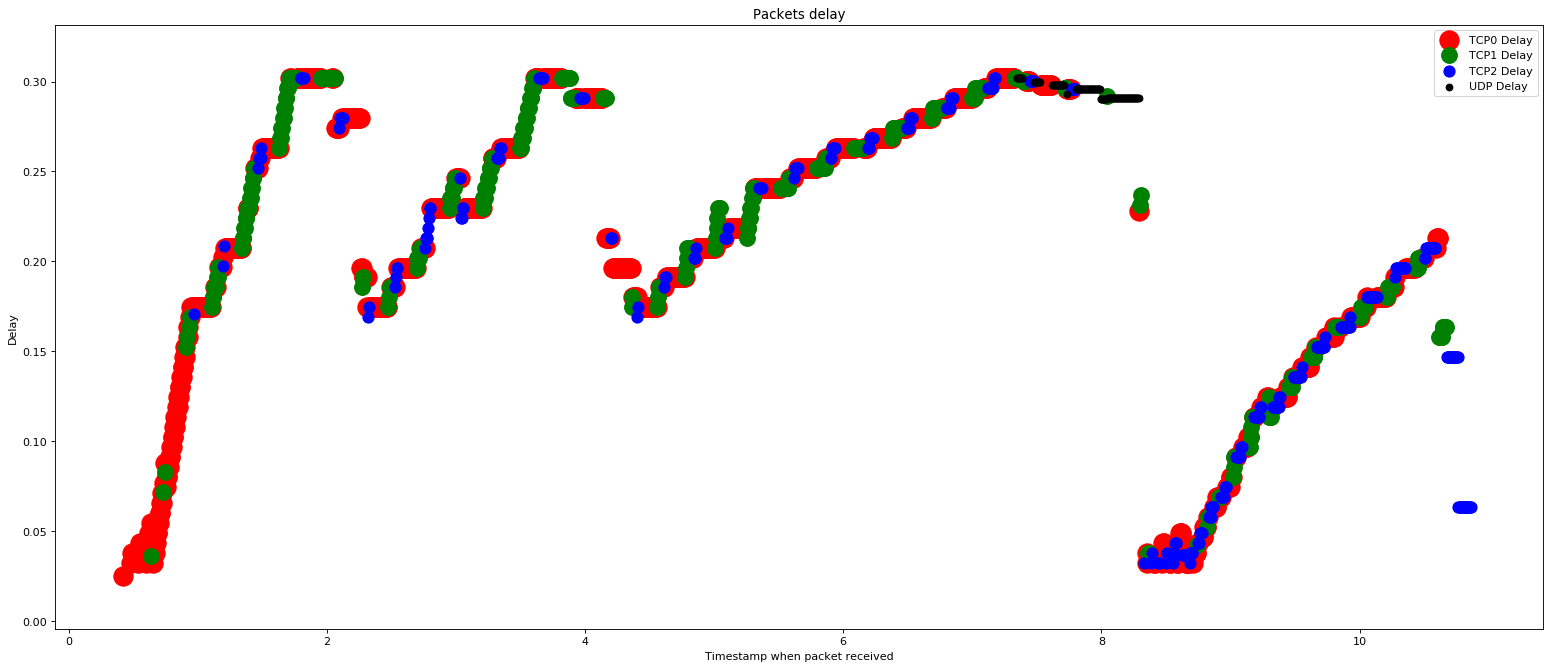

In [52]:
fig, ax = plt.subplots(figsize=(24, 10), dpi=80)
# ax.axes.get_xaxis().set_visible(False)
plt.scatter(pkt_id0, delay0, s=300, c='red', label='TCP0 Delay')
plt.scatter(pkt_id1, delay1, s=200, c='green', label='TCP1 Delay')
plt.scatter(pkt_id2, delay2, s=100, c='blue', label='TCP2 Delay')
plt.scatter(pkt_id3, delay3, c='black', label='UDP Delay')
plt.legend()
plt.title("Packets delay")
plt.xlabel("Timestamp when packet received")
plt.ylabel("Delay")